<a name="Libraries"></a>
## 1. Installing and importing libraries


In [2]:
%%capture
# Install relevant libraries
!pip install geopandas folium 

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score,RandomizedSearchCV,LeaveOneGroupOut,GroupKFold
import geopandas as gpd
from shapely.geometry import Point
import folium
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import optuna
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# You can ignore the Shapely GEOS warning :-)

In [4]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

<a name="Data"></a>
## 2. Loading and previewing data

In [ ]:
DATA_PATH = 'data/'  # Giả sử dữ liệu nằm trong thư mục 'data'
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51000,29.29000,2019,0,-0.00011,0.60302,-0.00007,0.25567,-98.59389,...,3664.43622,61085.80957,2615.12048,15.56853,0.27229,-12.62899,35.63242,-138.78642,30.75214,3.75099
1,ID_-0.510_29.290_2019_01,-0.51000,29.29000,2019,1,0.00002,0.72821,0.00001,0.13099,16.59286,...,3651.19031,66969.47873,3174.57242,8.69060,0.25683,30.35938,39.55763,-145.18393,27.25178,4.02518
2,ID_-0.510_29.290_2019_02,-0.51000,29.29000,2019,2,0.00051,0.74820,0.00038,0.11002,72.79584,...,4216.98649,60068.89445,3516.28267,21.10341,0.25110,15.37788,30.40182,-142.51954,26.19330,4.23138
3,ID_-0.510_29.290_2019_03,-0.51000,29.29000,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.50774,51064.54734,4180.97332,15.38690,0.26204,-11.29340,24.38036,-132.66583,28.82915,4.30529
4,ID_-0.510_29.290_2019_04,-0.51000,29.29000,2019,4,-0.00008,0.67630,-0.00005,0.12116,4.12127,...,3980.59812,63751.12578,3355.71011,8.11469,0.23585,38.53226,37.39298,-141.50981,22.20461,4.34732


## 🧹 Data Cleaning

### Drop columns with more than 90% missing values

In [6]:
train['emission_original'] = train['emission'].copy()

In [7]:
# Drop columns with >90% missing values
missing_ratio = train.isna().mean()
columns_to_drop = missing_ratio[missing_ratio > 0.9].index
train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)

## 🧠 Feature Engineering

### Add sine and cosine transformation of the week number and location identifier


In [8]:
# Create date column from year and week_no
train['date'] = pd.to_datetime(train['year'].astype(str) + '-' + train['week_no'].astype(str) + '-1', format='%Y-%W-%w')
test['date'] = pd.to_datetime(test['year'].astype(str) + '-' + test['week_no'].astype(str) + '-1', format='%Y-%W-%w')

# Create season column based on month
train['season'] = train['date'].dt.month.apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)
test['season'] = test['date'].dt.month.apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)
# Create holidays column based on specific weeks
train['holidays'] = train['week_no'].isin([0, 51, 12, 30])
test['holidays'] = test['week_no'].isin([0, 51, 12, 30])
# Create rotated coordinates features
train['rot_15_x'] = (np.cos(np.radians(15)) * train['longitude']) + (np.sin(np.radians(15)) * train['latitude'])
train['rot_15_y'] = (np.cos(np.radians(15)) * train['latitude']) + (np.sin(np.radians(15)) * train['longitude'])
train['rot_30_x'] = (np.cos(np.radians(30)) * train['longitude']) + (np.sin(np.radians(30)) * train['latitude'])
train['rot_30_y'] = (np.cos(np.radians(30)) * train['latitude']) + (np.sin(np.radians(30)) * train['longitude'])

test['rot_15_x'] = (np.cos(np.radians(15)) * test['longitude']) + (np.sin(np.radians(15)) * test['latitude'])
test['rot_15_y'] = (np.cos(np.radians(15)) * test['latitude']) + (np.sin(np.radians(15)) * test['longitude'])
test['rot_30_x'] = (np.cos(np.radians(30)) * test['longitude']) + (np.sin(np.radians(30)) * test['latitude'])
test['rot_30_y'] = (np.cos(np.radians(30)) * test['latitude']) + (np.sin(np.radians(30)) * test['longitude'])

In [9]:
# Adjust emissions for 2020 (COVID year) to align with non-COVID years (2019 and 2021)
# Calculate the average weekly emissions for non-virus years (2019 and 2021)
avg_emission_non_virus = train[train['year'].isin((2019, 2021))].groupby('week_no')['emission'].mean()

# Calculate the average weekly emissions for virus year (2020)
avg_emission_virus = train[train['year'] == 2020].groupby('week_no')['emission'].mean()

# Calculate the ratios for each week
ratios_for_weeks = avg_emission_non_virus / avg_emission_virus

# Multiply the emission column for each row in 2020 by the corresponding ratio for the week of that row
train.loc[train['year'] == 2020, 'emission'] *= train['week_no'].map(ratios_for_weeks)

# Fix the large spike in the last week of 2020 (week 52) as an outlier
train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'] = np.power(
    train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'], 1/1.5)

In [10]:
sin_week = np.sin(2 * np.pi * train['week_no'] / 53)
cos_week = np.cos(2 * np.pi * train['week_no'] / 53)
location = [f"{x}_{y}" for x, y in zip(train.latitude, train.longitude)]

emission_idx = train.columns.get_loc('emission')
train.insert(emission_idx, 'sin_week', sin_week)
train.insert(emission_idx + 1, 'cos_week', cos_week)
train.insert(emission_idx + 2, 'location', location)

sin_week_test = np.sin(2 * np.pi * test['week_no'] / 53)
cos_week_test = np.cos(2 * np.pi * test['week_no'] / 53)
location_test = [f"{x}_{y}" for x, y in zip(test.latitude, test.longitude)]

test.insert(emission_idx, 'sin_week', sin_week_test)
test.insert(emission_idx + 1, 'cos_week', cos_week_test)
test.insert(emission_idx + 2, 'location', location_test)


### Sort data by time and location to prepare for rolling mean calculation


In [11]:
train_eng = train.sort_values(by=['location', 'year', 'week_no'], ignore_index=True)
test_eng = test.sort_values(by=['location', 'year', 'week_no'], ignore_index=True)

### Select top 10 features most correlated with the emission target


In [12]:
original_features = [
    col for col in train_eng.columns 
    if not col.endswith('_roll_mean') and col not in ['emission','emission_original', 'ID_LAT_LON_YEAR_WEEK', 'location','date']
]

corrs = abs(train_eng[original_features + ['emission']].corr()['emission']).sort_values(ascending=False)
top20_original = corrs[corrs.index.isin(original_features)].head(10).index.tolist()


In [13]:
top20_original

['longitude',
 'rot_15_x',
 'rot_30_x',
 'rot_30_y',
 'Cloud_surface_albedo',
 'CarbonMonoxide_CO_column_number_density',
 'rot_15_y',
 'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
 'CarbonMonoxide_H2O_column_number_density',
 'Formaldehyde_tropospheric_HCHO_column_number_density']

### Compute rolling mean of selected features (window=7)


In [14]:
roll_mean_cols = top20_original
train_roll_mean = train.sort_values(by=['location', 'year', 'week_no']) \
    .groupby('location')[roll_mean_cols] \
    .rolling(window=7).mean().reset_index()
train_roll_mean.drop(['level_1', 'location'], axis=1, inplace=True)
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns]

test_roll_mean = test.sort_values(by=['location', 'year', 'week_no']) \
    .groupby('location')[roll_mean_cols] \
    .rolling(window=7).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis=1, inplace=True)
test_roll_mean.columns = [col + '_roll_mean' for col in test_roll_mean.columns]

In [15]:
train_eng['y_transformed'] = np.log1p(train_eng['emission'])

### Merge rolling mean features with the main datasets


In [16]:
train_eng = train_eng.merge(train_roll_mean, how='left', left_index=True, right_index=True)
test_eng = test_eng.merge(test_roll_mean, how='left', left_index=True, right_index=True)

In [17]:
# Fill NaN values in rolling mean columns with median
for col in train_eng.columns:
    if train_eng[col].isna().any():
        train_eng[col].fillna(train_eng[col].median(), inplace=True)
        if col in test_eng.columns:
            test_eng[col].fillna(train_eng[col].median(), inplace=True)

## ✅ Feature Selection

Use rolling mean features and engineered time features.


In [18]:
selected_features = [col + '_roll_mean' for col in top20_original 
                     if col + '_roll_mean' in train_eng.columns and col + '_roll_mean' in test_eng.columns]

# Replace longitude_roll_mean with original longitude
if 'longitude_roll_mean' in selected_features:
    selected_features.remove('longitude_roll_mean')
    selected_features.append('longitude')

# Add sine and cosine of week and latitude
for feat in ['sin_week', 'cos_week', 'latitude','season','holidays','rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y','year']:
    if feat not in selected_features:
        selected_features.append(feat)

In [19]:
# Remove redundant rotated coordinate rolling means
selected_features = [feat for feat in selected_features if feat not in [
    'rot_15_x_roll_mean', 'rot_30_x_roll_mean', 'rot_30_y_roll_mean', 'rot_15_y_roll_mean'
]]

In [20]:
train_eng.drop(columns=['ID_LAT_LON_YEAR_WEEK', 'date'], inplace=True)
test_eng.drop(columns=['ID_LAT_LON_YEAR_WEEK', 'date'], inplace=True)

In [21]:
selected_features

['Cloud_surface_albedo_roll_mean',
 'CarbonMonoxide_CO_column_number_density_roll_mean',
 'Formaldehyde_tropospheric_HCHO_column_number_density_amf_roll_mean',
 'CarbonMonoxide_H2O_column_number_density_roll_mean',
 'Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean',
 'longitude',
 'sin_week',
 'cos_week',
 'latitude',
 'season',
 'holidays',
 'rot_15_x',
 'rot_15_y',
 'rot_30_x',
 'rot_30_y',
 'year']

In [22]:
selected_features = [col for col in selected_features if col in train_eng.columns and col in test_eng.columns]

In [23]:
selected_features

['Cloud_surface_albedo_roll_mean',
 'CarbonMonoxide_CO_column_number_density_roll_mean',
 'Formaldehyde_tropospheric_HCHO_column_number_density_amf_roll_mean',
 'CarbonMonoxide_H2O_column_number_density_roll_mean',
 'Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean',
 'longitude',
 'sin_week',
 'cos_week',
 'latitude',
 'season',
 'holidays',
 'rot_15_x',
 'rot_15_y',
 'rot_30_x',
 'rot_30_y',
 'year']

## 🧪 Modeling

Train a `RandomForestRegressor` and evaluate performance using RMSE.


In [ ]:
X = train_eng[selected_features]
y = train_eng['emission']
X_test = test_eng[selected_features]

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
def optimize_model(trial, model_name, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []
    
    if model_name == 'rf':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_categorical('max_depth', [20, 40, None]),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3),
            'random_state': SEED
        }
        model = RandomForestRegressor(**params)
    elif model_name == 'xgb':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'random_state': SEED
        }
        model = XGBRegressor(**params)
    elif model_name == 'lgb':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 20, 50),
            'random_state': SEED,
            'verbose': -1
        }
        model = LGBMRegressor(**params)
    else:  # cb
        params = {
            'iterations': trial.suggest_int('iterations', 100, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
            'depth': trial.suggest_int('depth', 4, 8),
            'random_state': SEED,
            'verbose': 0
        }
        model = CatBoostRegressor(**params)
    
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = mean_squared_error(y_val, preds, squared=False)
        scores.append(score)
    
    return np.mean(scores)

In [ ]:
best_models = []
model_names = ['rf', 'xgb', 'lgb', 'cb']
for model_name in model_names:
    print(f"Tuning {model_name}...")
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: optimize_model(trial, model_name, X, y), n_trials=10)
    print(f"Best parameters for {model_name}: {study.best_params}")
    print(f"Best RMSE: {study.best_value:.5f}")
    
    # Initialize model with best parameters
    if model_name == 'rf':
        model = RandomForestRegressor(**study.best_params, random_state=SEED)
    elif model_name == 'xgb':
        model = XGBRegressor(**study.best_params, random_state=SEED)
    elif model_name == 'lgb':
        model = LGBMRegressor(**study.best_params, random_state=SEED, verbose=-1)
    else:
        model = CatBoostRegressor(**study.best_params, random_state=SEED, verbose=0)
    best_models.append((model_name, model))

In [25]:
k = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [26]:
def cross_val_score(model, cv=k, label=''):
    val_predictions = np.zeros((len(X)))
    train_scores, val_scores = [], []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        val_predictions[val_idx] += val_preds
        train_score = mean_squared_error(y_train, train_preds, squared=False)
        val_score = mean_squared_error(y_val, val_preds, squared=False)
        train_scores.append(train_score)
        val_scores.append(val_score)
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    return val_scores, val_predictions

In [51]:
models = [
    ('rf', RandomForestRegressor(n_estimators= 109, max_depth= None, min_samples_leaf= 2)),
    ('xgb', XGBRegressor(n_estimators= 177, learning_rate= 0.14347260931294858, max_depth= 7)),
    ('lgb', LGBMRegressor(n_estimators= 266, learning_rate= 0.15416009912090234, num_leaves= 34,force_row_wise=True)),
    ('cb', CatBoostRegressor(iterations= 247, learning_rate= 0.14254245134507781, depth= 8))
]

In [28]:
# Evaluate models
score_list = pd.DataFrame()
oof_list = pd.DataFrame()

for label, model in models:
    val_scores, val_predictions = cross_val_score(model, cv=k, label=label)
    score_list[label] = val_scores
    oof_list[label] = val_predictions

Val Score: 16.14033 ± 5.15718 | Train Score: 10.12520 ± 1.35279 | rf
Val Score: 14.85324 ± 4.60134 | Train Score: 4.71894 ± 0.30692 | xgb
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 63218, number of used features: 16
[LightGBM] [Info] Start training from score 84.770940
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 w

In [29]:
# Summarize mean RMSE
print("\nMean RMSE Summary:")
for label in score_list.columns:
    print(f"{label}: {np.mean(score_list[label]):.5f} ± {np.std(score_list[label]):.5f}")


Mean RMSE Summary:
rf: 16.14033 ± 5.15718
xgb: 14.85324 ± 4.60134
lgb: 17.21617 ± 4.27009
cb: 20.85931 ± 3.92188


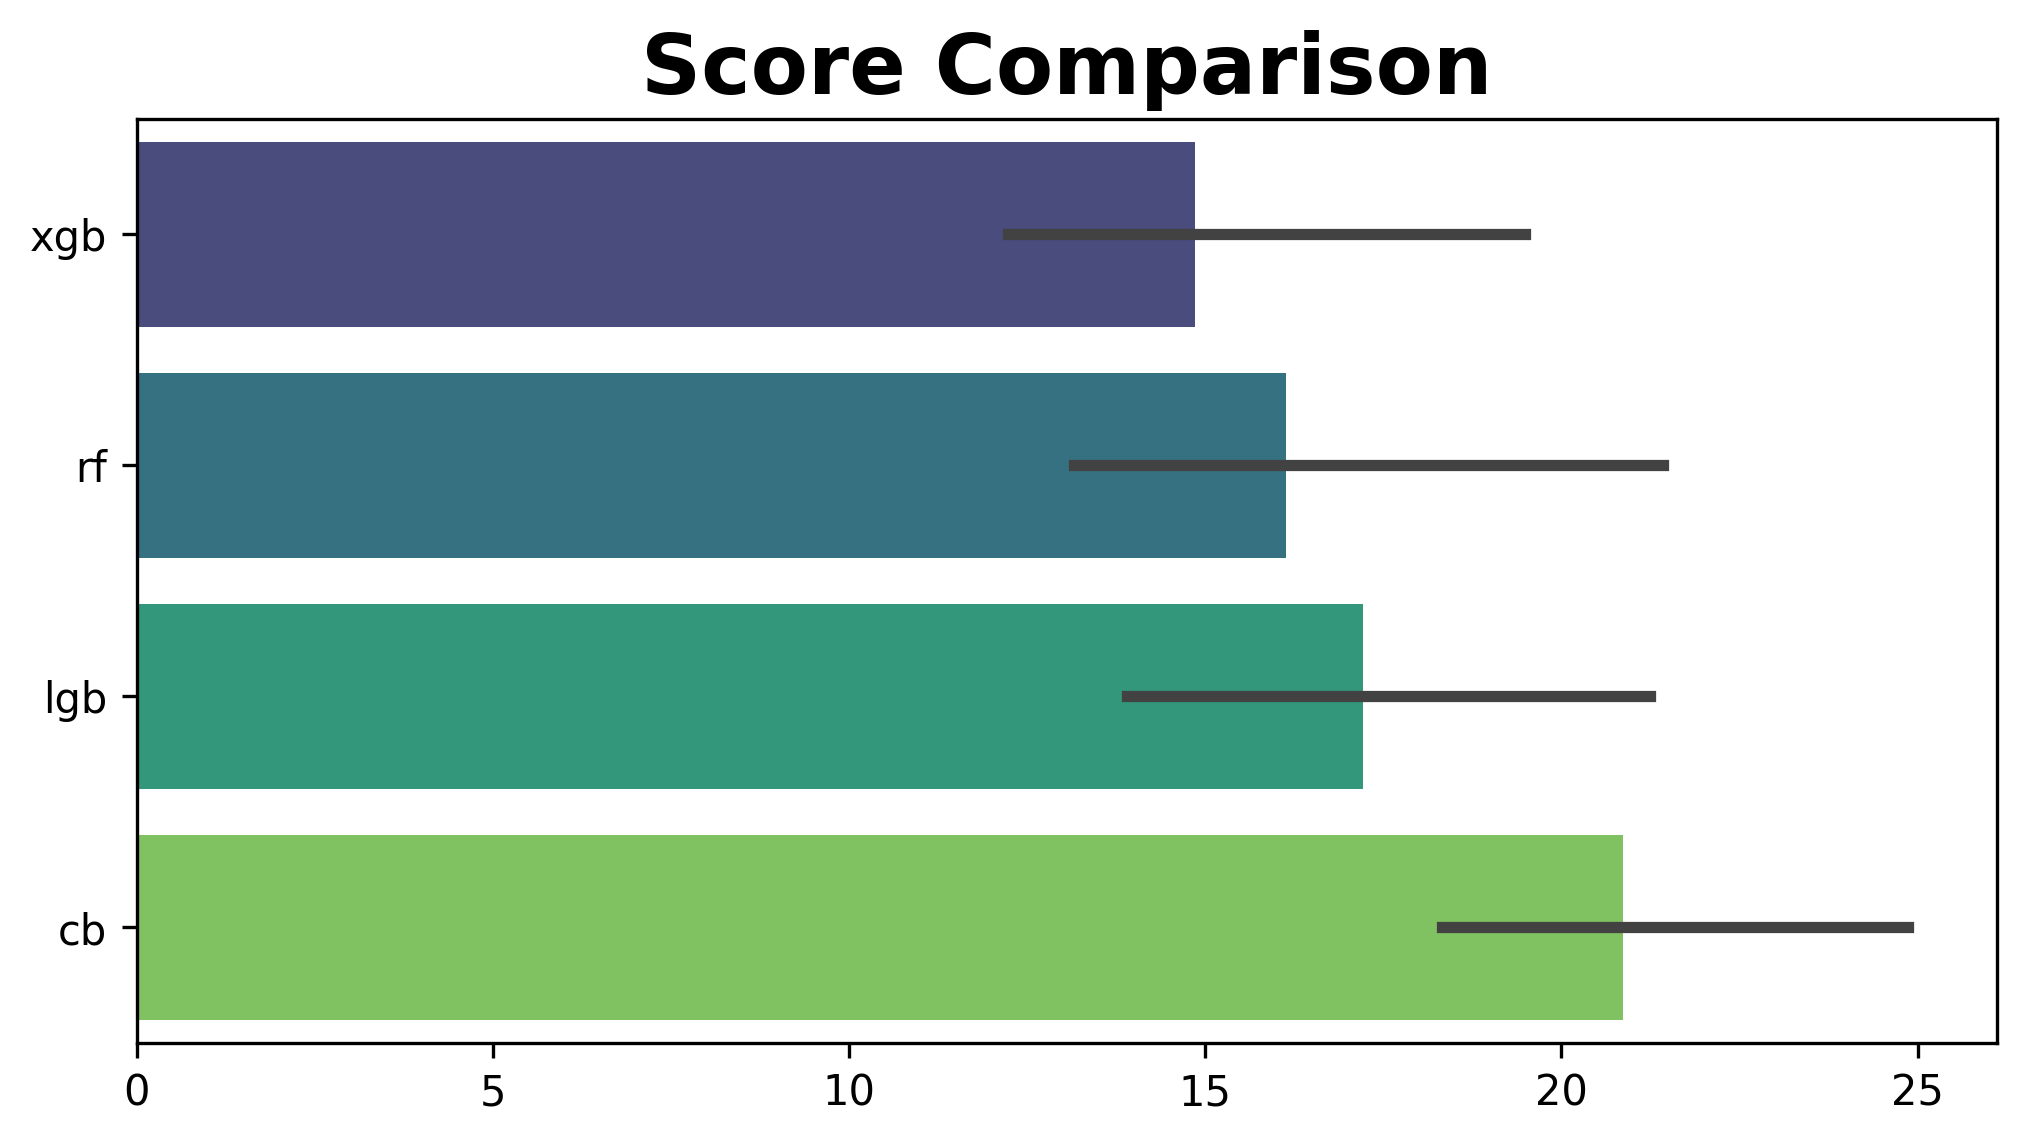

In [30]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((score_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 20)
plt.show()

In [52]:
best_md = RandomForestRegressor(n_estimators= 109, max_depth= None, min_samples_leaf= 2)

In [53]:
best_md.fit(X, y)

RandomForestRegressor(min_samples_leaf=2, n_estimators=109)

In [60]:
negative_count = np.sum(y_pred_test < 0)
print(f"Số lượng giá trị âm trong y_pred_test: {negative_count}")

Số lượng giá trị âm trong y_pred_test: 0


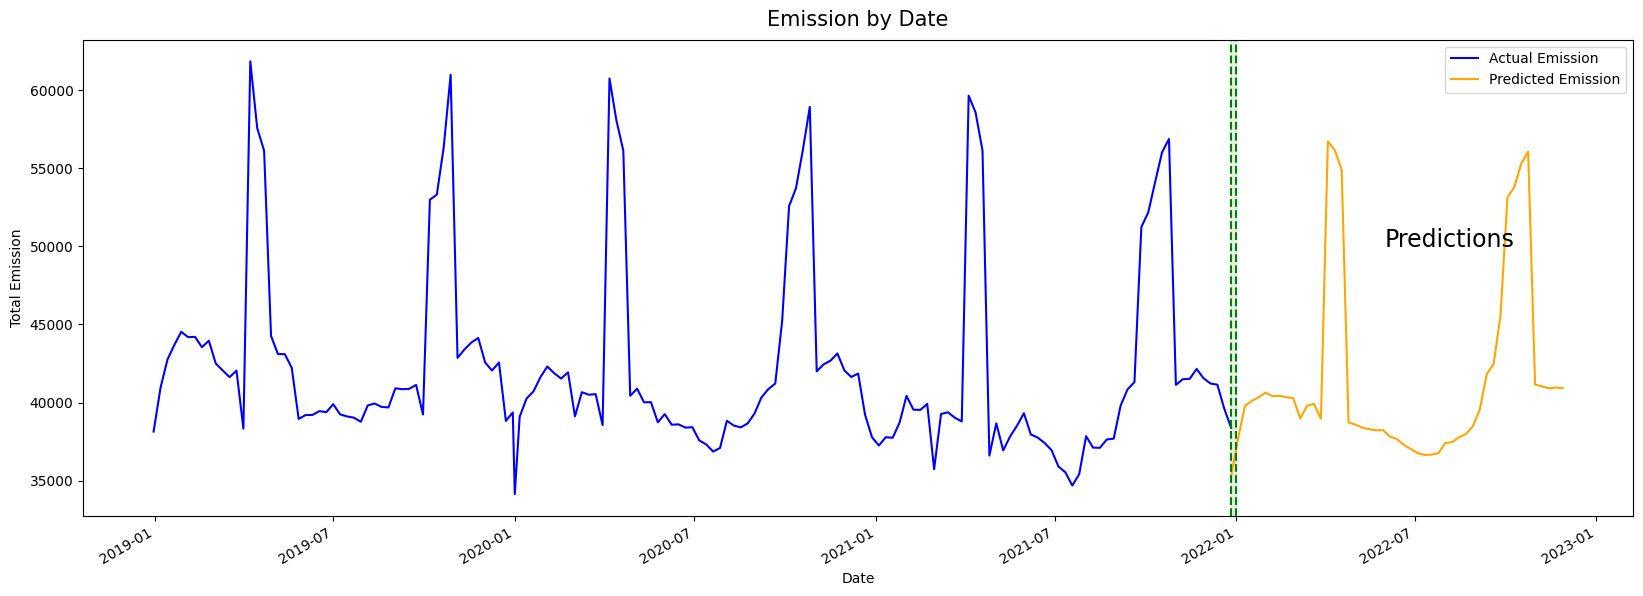

In [58]:
# Chuẩn bị dữ liệu train_plot theo date
train_plot = train.copy()
train_plot = train.groupby(['date'])['emission'].sum().reset_index()

# Chuẩn bị dữ liệu pred_plot theo date
pred_plot = test.copy()
pred_plot['emission'] = y_pred_test  # Gán giá trị dự đoán
pred_plot = pred_plot.groupby(['date'])['emission'].sum().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(20, 7))

# Vẽ đường cho train_plot (dữ liệu thực tế)
train_plot.groupby(['date'])['emission'].sum().plot(kind='line', label='Actual Emission', color='blue')

# Vẽ đường cho pred_plot (dự đoán)
pred_plot.groupby(['date'])['emission'].sum().plot(kind='line', label='Predicted Emission', color='orange')

# Thêm vùng tô màu và đường kẻ
# Đặt ranh giới dự đoán từ cuối 2021 đến đầu 2022
plt.axvspan(pd.Timestamp('2021-12-27'), pd.Timestamp('2022-01-01'), color='green', alpha=0.1)  # Vùng dự đoán
plt.axvline(pd.Timestamp('2021-12-27'), linestyle="--", color='green')  # Đường chấm tại cuối 2021
plt.axvline(pd.Timestamp('2022-01-01'), linestyle="--", color='green')  # Đường chấm tại đầu 2022

# Thêm nhãn cho vùng dự đoán
plt.text(pd.Timestamp('2022-06-01'), 50000, "Predictions", size=17)  # Điều chỉnh vị trí nhãn

# Thêm tiêu đề và nhãn
plt.title('Emission by Date', size=15, pad=10)
plt.xlabel('Date')
plt.ylabel('Total Emission')
plt.legend()

# Hiển thị biểu đồ
plt.show()

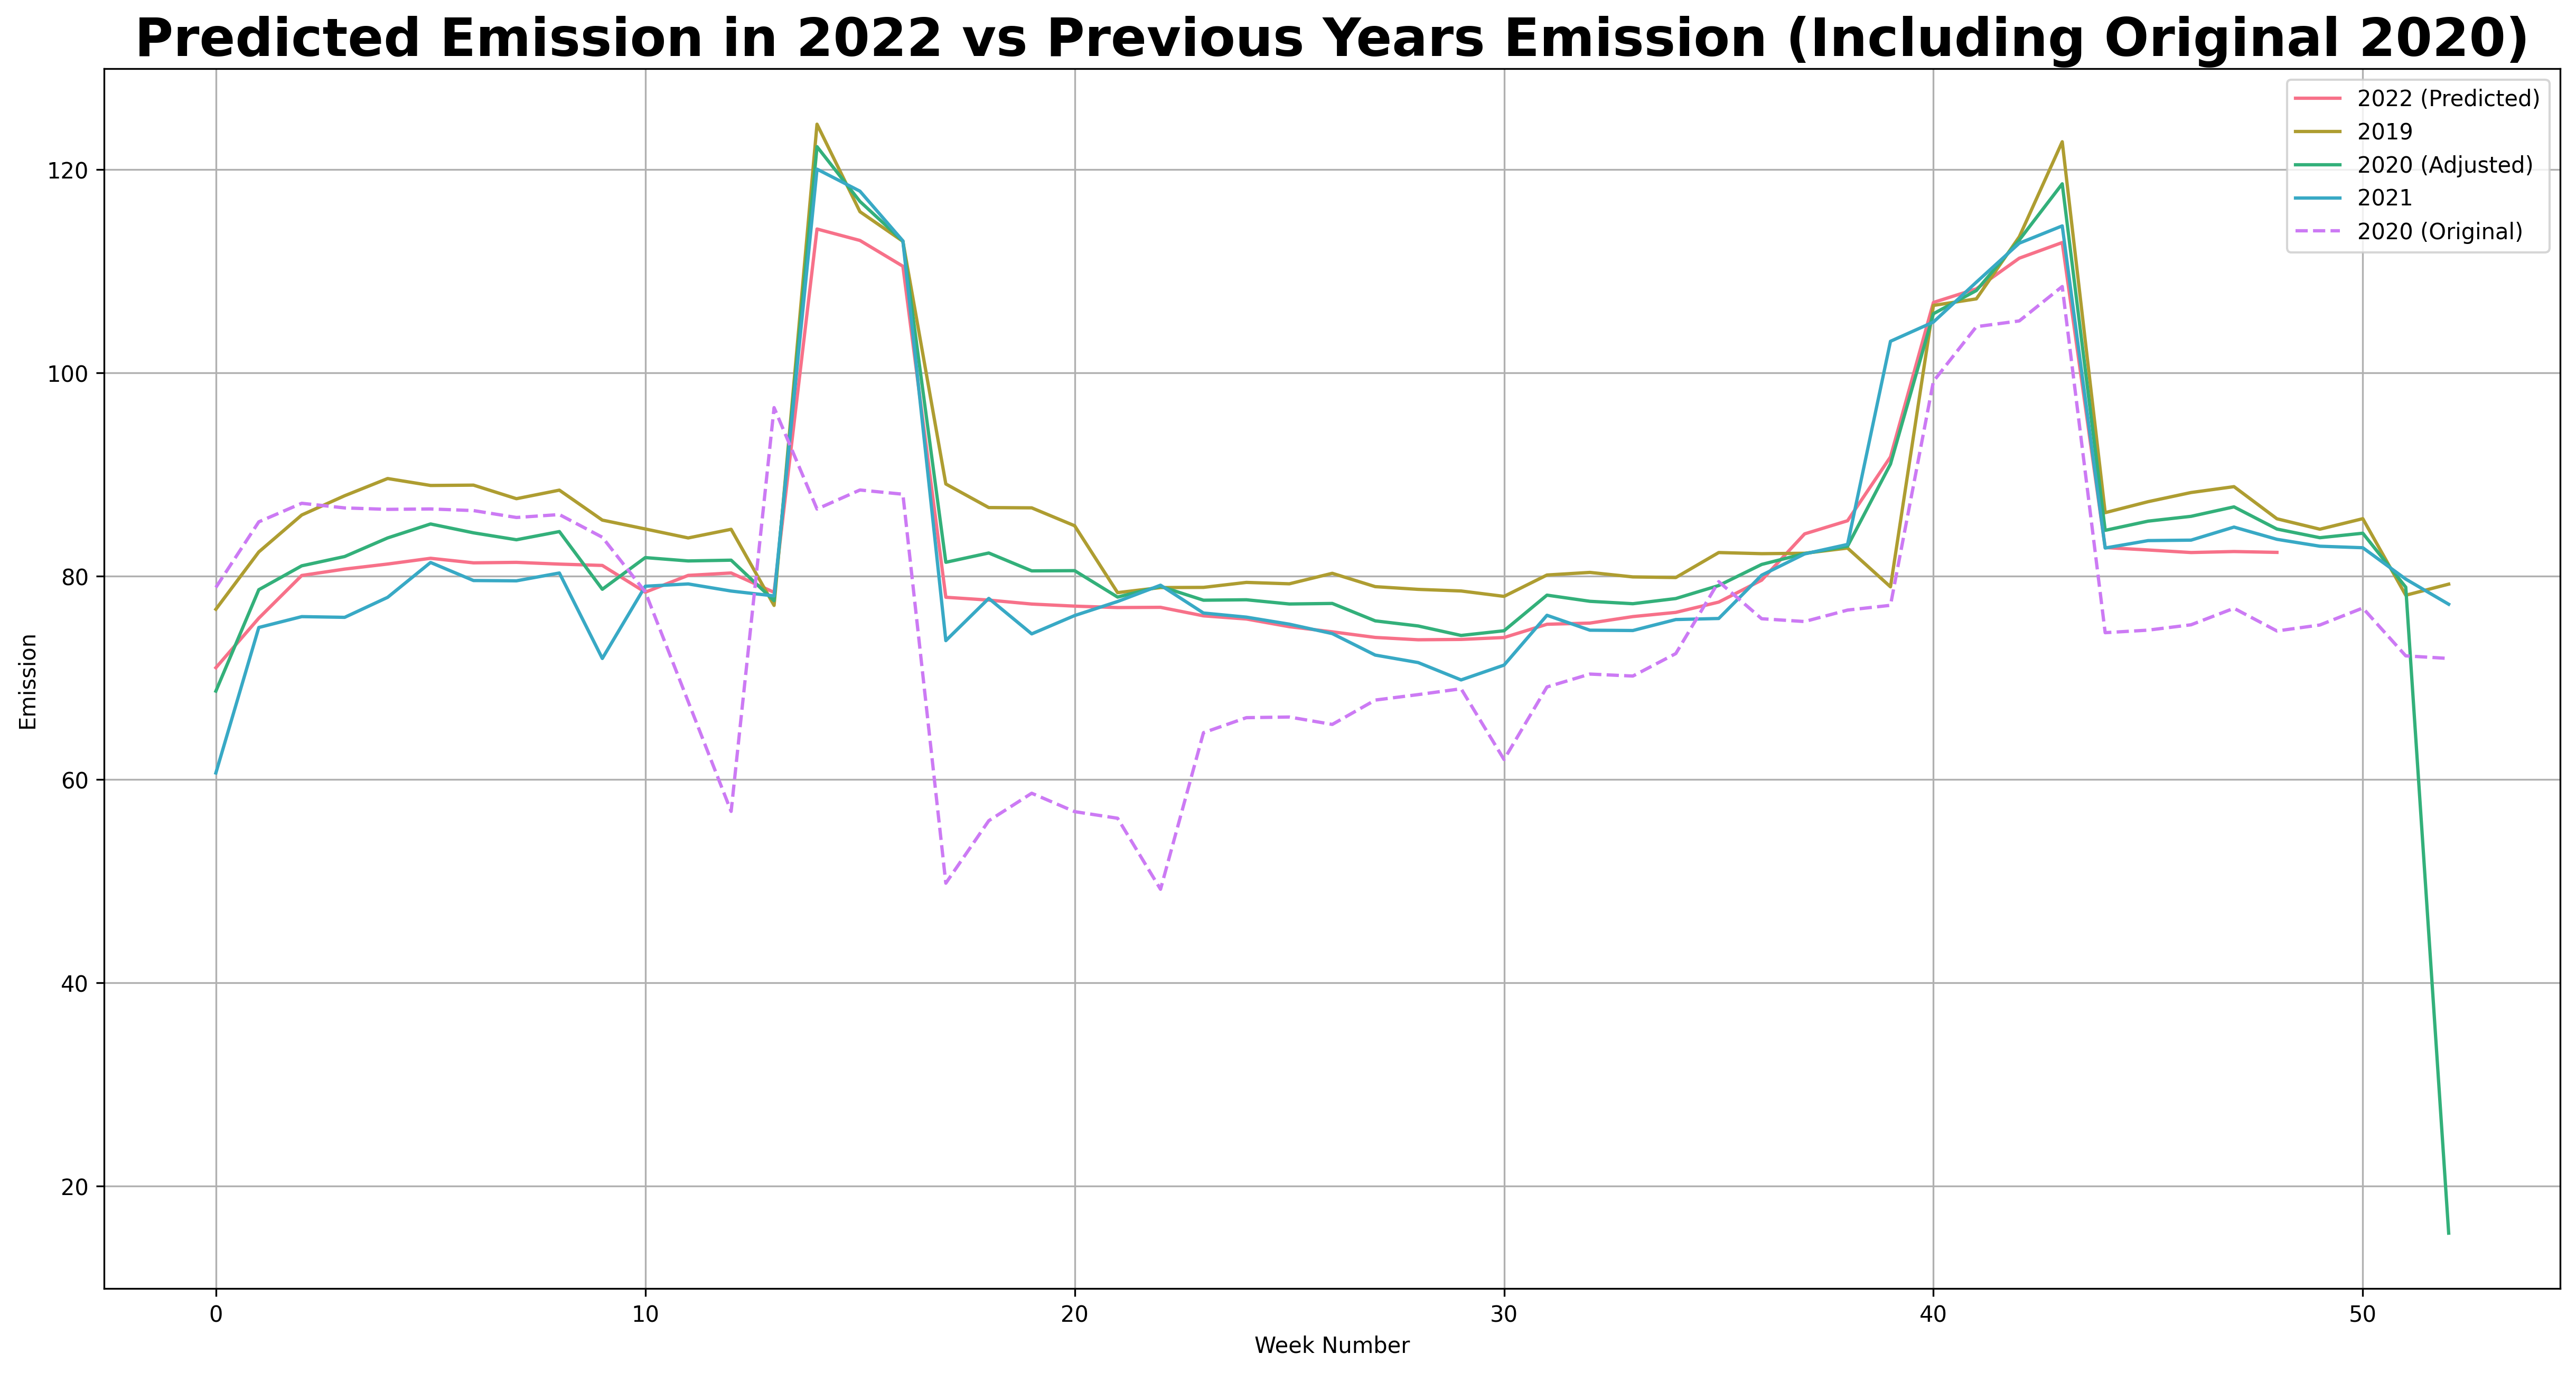

In [56]:
# Visualization
pal = sns.color_palette("husl", 5)

plt.figure(figsize=(20, 10), dpi=300)

# Plot predicted emission for 2022 (test set)
sns.lineplot(x=test.week_no, y=y_pred_test, errorbar=None, label='2022 (Predicted)', color=pal[0])

# Plot actual emission for previous years (train set, adjusted data)
sns.lineplot(x=train.week_no, y=train.emission, hue=train.year, errorbar=None, 
             palette=[pal[1], pal[2], pal[3]], legend=False)

# Plot original emission for 2020
sns.lineplot(x=train[train['year'] == 2020].week_no, y=train[train['year'] == 2020].emission_original, 
             errorbar=None, label='2020 (Original)', color=pal[4], linestyle='--')

plt.legend(['2022 (Predicted)', 2019, '2020 (Adjusted)', 2021, '2020 (Original)'], loc='upper right')
plt.title('Predicted Emission in 2022 vs Previous Years Emission (Including Original 2020)', fontsize=24, fontweight='bold')
plt.xlabel('Week Number')
plt.ylabel('Emission')
plt.grid(True)
plt.show()

In [59]:
submission_df = test[['longitude', 'latitude', 'year', 'week_no']].copy()

# Add the predicted emission column
submission_df['emission'] = y_pred_test  # test_pred from Final Prediction (voter.predict(X_test))

# Save to CSV
submission_df.to_csv('submission_with_coords.csv', index=False)
print("Custom submission file created: submission_with_coords.csv")
print(submission_df.head())  # Preview the first few rows

Custom submission file created: submission_with_coords.csv
   longitude  latitude  year  week_no  emission
0   29.29000  -0.51000  2022        0   3.49951
1   29.29000  -0.51000  2022        1   3.99020
2   29.29000  -0.51000  2022        2   4.17900
3   29.29000  -0.51000  2022        3   4.19270
4   29.29000  -0.51000  2022        4   4.23018
